# Method Analysis: Query Examples and Feature Investigation

This notebook provides detailed analysis for a single method:
- Selects N good, N bad, and N intermediate queries based on a metric
- Visualizes query results with group annotations
- (Future) Feature-level analysis for understanding misclassifications

For cross-method comparison, see `overview.ipynb`.

**Note:** Additional metrics (recall@1, recall@2, etc.) are computed on-demand and cached in `enriched_cache/`.
To force recomputation, delete the cache directory.

Adjust the configuration cell below and run the notebook top-to-bottom.


In [27]:
# === Imports ===
from pathlib import Path
import pandas as pd
from sim_bench.analysis import utils
from sim_bench.analysis.config import GlobalAnalysisConfig, set_global_config
from sim_bench.analysis.io import load_per_query, load_rankings, load_enriched_per_query
from sim_bench.analysis.plotting import plot_query_topn_grid, PlotGridConfig

# === Configuration ===
PROJECT_ROOT = utils.get_project_root()

# Experiment settings (relative to project root)
EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "baseline_runs" / "comprehensive_baseline" / "2025-10-08_16-25-49"
METHOD = "deep"
RANKING_METRIC = "ap@10"  # Metric to rank queries (recall@1, ap_full, ap@10, ns_hitcount@4, etc.)

# Analysis settings
TOP_N = 6
MAX_PER_ROW = 3
NUM_IMAGES_PER_GROUP = 2  # Number of queries to select from each group (good/intermediate/bad)

# Dataset configuration
DATASET_NAME = "ukbench"
DATASET_CONFIG = {
    "name": "ukbench",
    "root": "D:/Similar Images/DataSets/ukbench",
    "subdirs": {"images": "full"},
    "pattern": "*.jpg"
}

# Export settings
EXPORT_PDF = True  # Set to True to export this notebook as PDF after running

# === Validation ===
if not EXPERIMENT_DIR.exists():
    raise FileNotFoundError(
        f"Experiment directory not found: {EXPERIMENT_DIR}\n"
        f"Project root: {PROJECT_ROOT}\n"
        f"Please update EXPERIMENT_DIR in the configuration above."
    )

method_dir = EXPERIMENT_DIR / METHOD
if not method_dir.exists():
    available = [d.name for d in EXPERIMENT_DIR.iterdir() if d.is_dir() and not d.name.startswith('.')]
    raise FileNotFoundError(
        f"Method '{METHOD}' not found in {EXPERIMENT_DIR}\n"
        f"Available methods: {available}"
    )

# Set global config
set_global_config(GlobalAnalysisConfig(experiment_dir=EXPERIMENT_DIR).resolve())
plot_cfg = PlotGridConfig(top_n=TOP_N, max_per_row=MAX_PER_ROW, save=False)

print(f"✓ Configuration validated")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Experiment: {EXPERIMENT_DIR.relative_to(PROJECT_ROOT)}")
print(f"  Method: {METHOD}")
print(f"  Ranking by: {RANKING_METRIC}")


✓ Configuration validated
  Project root: D:\sim-bench
  Experiment: outputs\baseline_runs\comprehensive_baseline\2025-10-08_16-25-49
  Method: deep
  Ranking by: ap@10


In [20]:
# Load per-query and rankings with enrichment caching
df_results_per_query = load_enriched_per_query(METHOD, k_values=[1, 2, 3, 4, 5])
df_rankings = load_rankings(METHOD)

available_metrics = [c for c in df_results_per_query.columns if c not in ['query_idx', 'query_path', 'group_id']]
print(f"✓ Loaded {len(df_results_per_query)} queries, {len(df_rankings)} rankings")
print(f"  Available metrics: {available_metrics}")

# Validate RANKING_METRIC
if RANKING_METRIC not in df_results_per_query.columns:
    raise ValueError(
        f"Metric '{RANKING_METRIC}' not found in per_query.csv!\n"
        f"  Available metrics: {available_metrics}\n\n"
        f"Either:\n"
        f"  1. Change RANKING_METRIC in the configuration cell\n"
        f"  2. Metrics are auto-computed by load_enriched_per_query() and cached"
    )

df_results_per_query.head()


✓ Loaded 10200 queries, 102000 rankings
  Available metrics: ['ns_hitcount@4', 'ap@10', 'recall@1', 'recall@2', 'recall@3', 'recall@4', 'recall@5']


query_idx                                         query_path  group_id  \
0          0  D:\Similar Images\DataSets\ukbench\full\ukbenc...         0   
1          1  D:\Similar Images\DataSets\ukbench\full\ukbenc...         0   
2          2  D:\Similar Images\DataSets\ukbench\full\ukbenc...         0   
3          3  D:\Similar Images\DataSets\ukbench\full\ukbenc...         0   
4          4  D:\Similar Images\DataSets\ukbench\full\ukbenc...         1   

   ns_hitcount@4     ap@10  recall@1  recall@2  recall@3  recall@4  recall@5  
0              3  1.000000  0.333333  0.666667  1.000000  1.000000  1.000000  
1              3  0.916667  0.333333  0.666667  0.666667  1.000000  1.000000  
2              3  1.000000  0.333333  0.666667  1.000000  1.000000  1.000000  
3              2  0.809524  0.333333  0.666667  0.666667  0.666667  0.666667  
4              3  1.000000  0.333333  0.666667  1.000000  1.000000  1.000000

In [21]:
# Validate the configured metric exists
if RANKING_METRIC not in df_results_per_query.columns:
    available_metrics = [col for col in df_results_per_query.columns if col not in ["query_idx", "query_path", "group_id"]]
    raise ValueError(
        f"Metric '{RANKING_METRIC}' not found in per_query.csv!\n"
        f"  Available metrics: {available_metrics}\n\n"
        f"Either:\n"
        f"  1. Change RANKING_METRIC in the configuration cell to one of the available metrics\n"
        f"  2. Use load_enriched_per_query() to compute additional metrics like recall@1"
    )

print(f"Ranking queries by: {RANKING_METRIC}")

# Define selectors for good / bad / intermediate
df_sorted = df_results_per_query.sort_values(RANKING_METRIC, ascending=False)

# Best: highest metric values (top N)
best_rows = df_sorted.head(NUM_IMAGES_PER_GROUP)

# Worst: lowest metric values (bottom N)
worst_rows = df_sorted.tail(NUM_IMAGES_PER_GROUP)

# Intermediate: exclude best and worst values, then pick around median
max_val = df_sorted[RANKING_METRIC].max()
min_val = df_sorted[RANKING_METRIC].min()
df_middle = df_sorted[(df_sorted[RANKING_METRIC] != max_val) & (df_sorted[RANKING_METRIC] != min_val)]

if not df_middle.empty and len(df_middle) >= NUM_IMAGES_PER_GROUP:
    median_val = df_middle[RANKING_METRIC].median()
    # Sort by distance from median and take N closest
    df_middle_sorted = df_middle.iloc[(df_middle[RANKING_METRIC] - median_val).abs().argsort()]
    intermediate_rows = df_middle_sorted.head(NUM_IMAGES_PER_GROUP)
else:
    # Fallback: take N from the middle of the sorted list
    mid_idx = len(df_sorted) // 2
    start_idx = max(0, mid_idx - NUM_IMAGES_PER_GROUP // 2)
    intermediate_rows = df_sorted.iloc[start_idx:start_idx + NUM_IMAGES_PER_GROUP]

# Create a summary dataframe of selected queries
import pandas as pd
selected_rows = []

for _, row in best_rows.iterrows():
    r = row.copy()
    r["label"] = "good"
    selected_rows.append(r)

for _, row in intermediate_rows.iterrows():
    r = row.copy()
    r["label"] = "intermediate"
    selected_rows.append(r)

for _, row in worst_rows.iterrows():
    r = row.copy()
    r["label"] = "bad"
    selected_rows.append(r)

df_selected = pd.DataFrame(selected_rows)
df_selected = df_selected[["label", "query_idx", RANKING_METRIC, "query_path"]]

print(f"\n=== Selected Queries ({NUM_IMAGES_PER_GROUP} per group) ===")
df_selected


Ranking queries by: ap@10

=== Selected Queries (2 per group) ===


label  query_idx     ap@10  \
0             good          0  1.000000   
6321          good       6321  1.000000   
7146  intermediate       7146  0.722222   
8876  intermediate       8876  0.722222   
7168           bad       7168  0.000000   
5492           bad       5492  0.000000   

                                             query_path  
0     D:\Similar Images\DataSets\ukbench\full\ukbenc...  
6321  D:\Similar Images\DataSets\ukbench\full\ukbenc...  
7146  D:\Similar Images\DataSets\ukbench\full\ukbenc...  
8876  D:\Similar Images\DataSets\ukbench\full\ukbenc...  
7168  D:\Similar Images\DataSets\ukbench\full\ukbenc...  
5492  D:\Similar Images\DataSets\ukbench\full\ukbenc...

In [22]:
# Placeholder cell - can be removed


=== GOOD — query_idx=0, ap@10=1.0000 ===

=== GOOD — query_idx=6321, ap@10=1.0000 ===

=== INTERMEDIATE — query_idx=7146, ap@10=0.7222 ===

=== INTERMEDIATE — query_idx=8876, ap@10=0.7222 ===

=== BAD — query_idx=7168, ap@10=0.0000 ===

=== BAD — query_idx=5492, ap@10=0.0000 ===


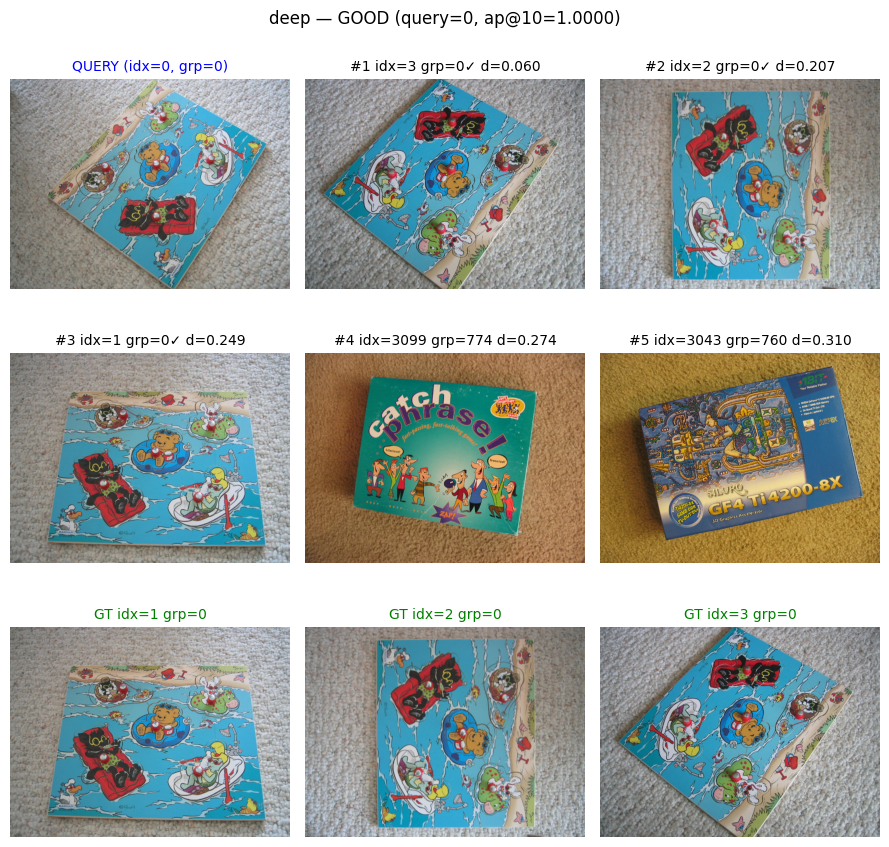

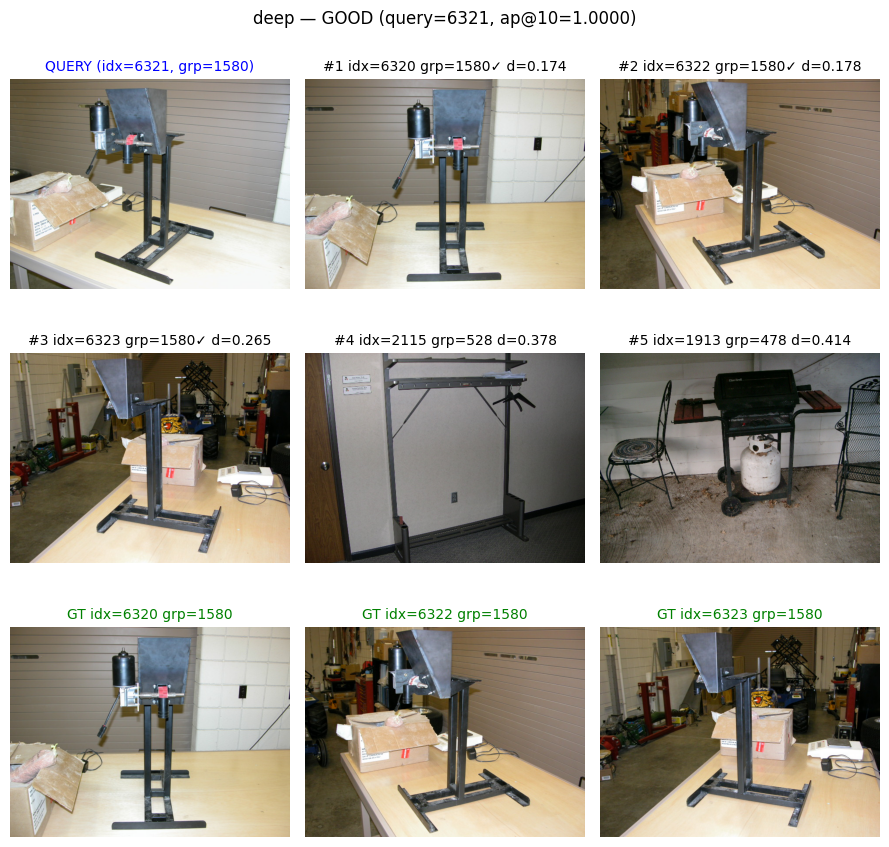

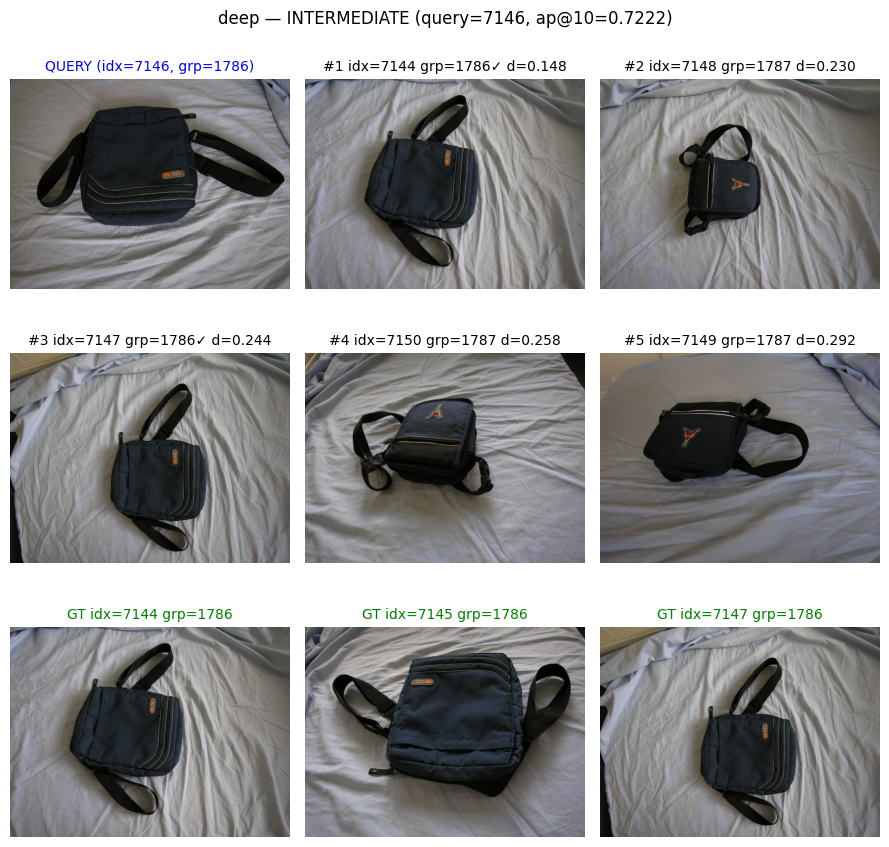

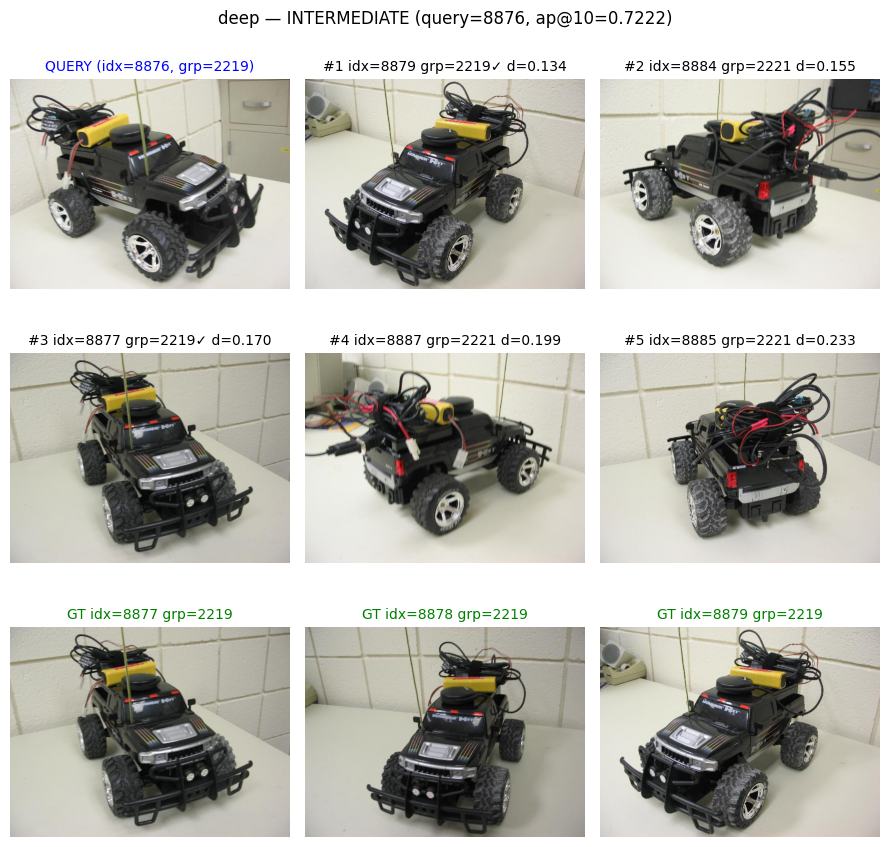

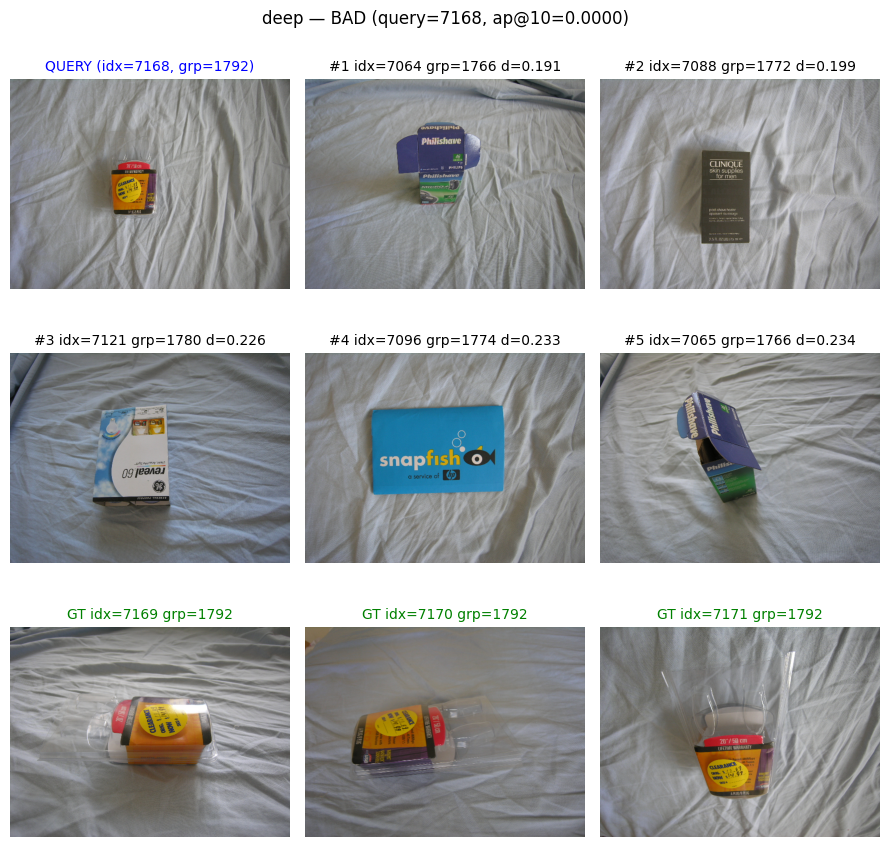

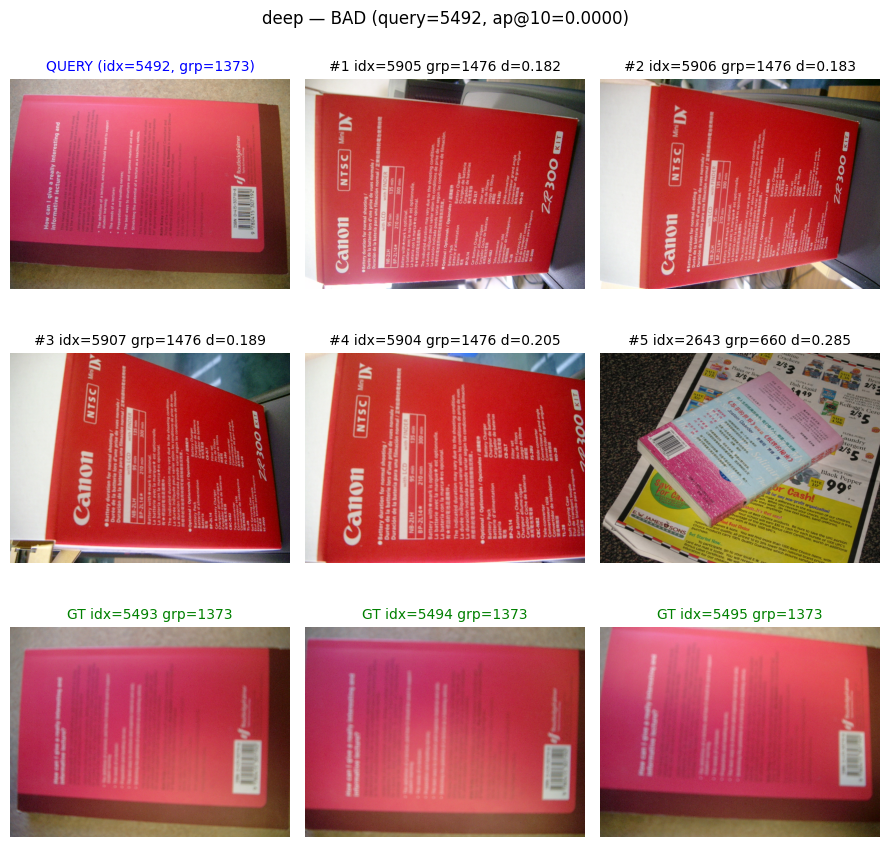

In [23]:
# Visualize all selected queries
for _, row in df_selected.iterrows():
    label = row["label"]
    qidx = int(row["query_idx"])
    metric_value = row[RANKING_METRIC]
    
    # Create custom suptitle with label and metric
    suptitle = f"{METHOD} — {label.upper()} (query={qidx}, {RANKING_METRIC}={metric_value:.4f})"
    
    print(f"\n=== {label.upper()} — query_idx={qidx}, {RANKING_METRIC}={metric_value:.4f} ===")
    plot_query_topn_grid(METHOD, qidx, plot_cfg, DATASET_NAME, DATASET_CONFIG, suptitle=suptitle, show_ground_truth=True)


In [29]:
# === Export to PDF (Optional) ===
if EXPORT_PDF:
    try:
        from sim_bench.analysis.export import export_notebook_to_pdf
        
        # Get this notebook's absolute path (relative to project root)
        notebook_path = PROJECT_ROOT / "sim_bench" / "analysis" / "method_analysis.ipynb"
        output_dir = EXPERIMENT_DIR / "analysis_reports"
        
        pdf_path = export_notebook_to_pdf(notebook_path, output_dir=output_dir)
        print(f"✓ Exported to PDF: {pdf_path}")
    except ImportError:
        print("⚠ PDF export requires: pip install nbconvert[webpdf]")
    except Exception as e:
        print(f"⚠ PDF export failed: {e}")
else:
    print("PDF export disabled. Set EXPORT_PDF = True in configuration to enable.")


✓ Exported to PDF: D:\sim-bench\outputs\baseline_runs\comprehensive_baseline\2025-10-08_16-25-49\analysis_reports\method_analysis_20251020_223955.pdf
